# SVM for MNIST 5

# Import des données

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import pandas as pd
train_data = pd.read_csv('mnist_train.csv' , sep=',',header=None)
test_data = pd.read_csv('mnist_test.csv' , sep=',',header=None)

In [3]:
y_train = train_data[0] # Labels du train set
y_test = test_data[0]  # Labels du test set

In [4]:
y_train[y_train != 0] = -1 # On se place dans le cadre d'une classification 4 ou non 4 
y_train[y_train == 0 ] = 1

In [5]:
y_test[y_test != 0] = -1 # On se place dans le cadre d'une classification 4 ou non 4 
y_test[y_test == 0 ] = 1

In [6]:
X_train = train_data.iloc[:,1:] # On récupère les pixels, sous forme de tableau
X_test = test_data.iloc[:,1:]

In [7]:
np.array(X_train.loc[0,]).flatten() # Ici on récupère par exemple le np.array contenant les pixels du premier élément

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [8]:
np.array(X_train.loc[0,]).flatten().shape

(784,)

# Gradients

In [9]:
def loss_grad(x,x_train,y_train,l_coeff):
    """
    x est un vecteur de IR^d, donc ici de taille 784
    x_train est un vecteur de IR^d également, on calcule le ps de x et x_train et on voit s'il est supérieur ou 
    égal a 1
    y_train est le label de x_train
    """
    threshold = x_train.dot(x)*y_train
    grad = (-y_train*x_train)*(threshold < 1)
    return(l_coeff*grad + x)

                               
    

In [10]:
def sum_loss_grad(x,x_data,y_data,ind,l_coeff):
    somme = 0
    for i in ind:
        somme += loss_grad(x,np.array(x_data.loc[i,]),y_data[i],l_coeff)
    return(somme)

# Fonctions de perte

In [11]:
# Regret/Perte régularisée ponctuelle en évaluée en x 
# Pour ai, bi, et lbd le paramètre de régularisation lambda 

def insthingereg(x,a,b,lbd): 
    """
    a est un vecteur de IR^d ( 784 )
    b est un label 
    x est un vecteur de IR^d ( 784 )
    """
    threshold = a.dot(x) * b 
    cost = 1 - a.dot(x) * b 
    cost = cost*(threshold < 1) 
    return(lbd*cost+x.dot(x)/2)

# Projections 

In [12]:
def pisimplex(v,r):
    n = len(v)
    u = np.sort(v)[-1::-1]
    su = np.cumsum(u)
    
    
    rho_i = (u > (su - r)*np.array([1/(n) for i in range(n)]))
    rho_i = rho_i*np.array([i+1 for i in range(n)])
    rho = np.max(rho_i)
    
    
    theta = (su[rho-1] - r)/rho
    
    w = v - theta
    w[w < 0] = 0
    return(w)

In [13]:
def pib1(x,r):
    v = np.abs(x)
    if np.sum(v) > r:
        w = pisimplex(v,r)
        x = np.sign(x)*w
    return(x)

In [14]:
def pib1w(x,w,r): # Utilisé pour Adagrad
    n = len(x)
    v = np.abs(x*w)
    u = np.argsort(-v) # tri et indices dans l'ordre croissant
    
    sx = np.cumsum(np.abs(x)[u])
    
    sw = np.cumsum(1/w[u])
    
    #rho <- max(which(v[u] > (sx-z) / sw))
    rho_i = (v[u] > (sx - r)/sw)*np.array([i+1 for i in range(n)]) 
    rho = np.max(rho_i)
    
    #theta <- (sx[rho] -z) / sw[rho]
    theta = (sx[rho] - r)/sw[rho]
    
    if np.sum(np.abs(x) > r):
        w_i = np.abs(x) - theta/w
        w_i[w_i < 0 ] = 0
        x = np.sign(x)*w_i
    return(x)
    

# Gradient Descent, full batch 

In [15]:
def grad_desc(x_data,y_data,l_coeff,n_iter):
    dim = x_data.loc[1,].shape[0]
    x = np.random.random(dim)
    n = x_data.shape[0]
    
    
    for t in tqdm(range(n_iter)):
        grad = (1/n)*sum_loss_grad(x,x_data,y_data,range(n),l_coeff) + x
        
        eta = 2/(t+1)
        x = x - eta*grad
        

    return(x)

In [16]:
# Test
#slope_gd = grad_desc(X_train,y_train,1,100)

# Stochastic Gradient Descent

In [17]:
def sgd_proj(x_data,y_data,n_iter,batch_size,l_coeff,radius):
    
    dim = x_data.loc[1,].shape[0]
    x = np.random.random(dim)
    n = x_data.shape[0] # nombre de données
    sum_xn = np.zeros(dim)
    
    theta_track = []
    theta_var = []
    reg = []
    
    var = 0
    for t in tqdm(range(n_iter)):
        sample = np.random.randint(n,size=batch_size)
        
        expected_grad = (1/(batch_size))*(sum_loss_grad(x,x_data,y_data,sample,l_coeff)) + x
        
        eta = 2/(t+1)
        
        x = pib1(x - eta*expected_grad,radius)
        
        
        
        sum_xn += x # Somme pour l'averaging step
        
        sn = (1/(t+1))*sum_xn
        
        theta_track.append(sn)
        
        if batch_size == 1:
            a = np.array(x_data.loc[sample,])
            b = b = y_data[sample]
            instant_reg = float(insthingereg(sn,a,b,l_coeff))
        reg.append(instant_reg)
        
        
        
        if t > 2:
            var = np.sum(np.abs(theta_track[t]-theta_track[t-1]))
        theta_var.append(var)
    
    return((1/n_iter)*sum_xn,theta_track,theta_var,reg)
            
            
            
            
            

100%|██████████| 10000/10000 [00:21<00:00, 474.77it/s]


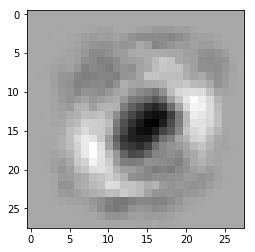

In [18]:
# Tests

slope_sgd,track_sgd,var_sgd,reg_sgd = sgd_proj(X_train,y_train,10000,1,1,2000)

slope_reshape = slope_sgd.reshape(28,28)
plt.imshow(slope_reshape, cmap='gray')
plt.show()

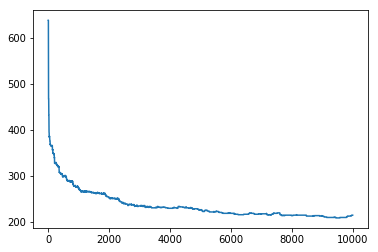

In [19]:
# Nombre de coordonnées non nulles

nb_non_nul_sgd = []
for k in range(10000):
    nb_non_nul_sgd.append(np.sum(np.abs(track_sgd[k]) < 0.001))
plt.plot(range(10000),nb_non_nul_sgd)

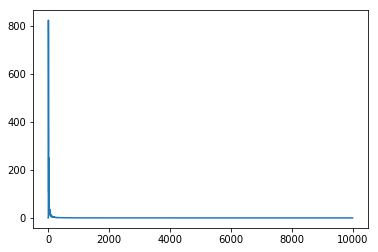

In [20]:
# Variations du paramètre
plt.plot(range(10000),var_sgd)


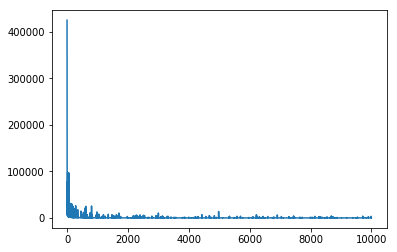

In [21]:
# Regret instantané
plt.plot(range(10000),reg_sgd)


# Stochastic Mirror Descent

In [22]:
def sto_md(x_data,y_data,n_iter,theta_ini,l_coeff,r):
    
    dim = x_data.loc[1,].shape[0] # taille du vecteur
    n = x_data.shape[0] # nombre de données
    
    theta_track = []
    theta = theta_ini
    
    theta_var = []
    var = 0
    
    reg = []
    sum_theta = 0
    for t in tqdm(range(n_iter)):
        ind = int(np.random.randint(n,size=1))
        eta = 1/np.sqrt(t+1) # éventuellement learning rate = 1/t
        
        a = np.array(x_data.loc[ind,])
        b = y_data[ind]
        
        # On garde en mémoire theta
        theta = theta -  eta*(loss_grad(theta,a,b,l_coeff)   + theta  )
        theta = pib1(theta,r)
        
        theta_track.append(theta)
        
        #regret instantané
        
        sum_theta += theta 
        moy_theta = sum_theta/(t+1)
        
        instant_regret = float(insthingereg(moy_theta,a,b,l_coeff))
        reg.append(instant_regret)
        
        
        #variations de theta
        if t > 2:
            var = np.sum(np.abs(theta_track[t]-theta_track[t-1]))
        theta_var.append(var)
        
    return(theta,theta_track,theta_var,reg)

100%|██████████| 20000/20000 [00:08<00:00, 2413.46it/s]


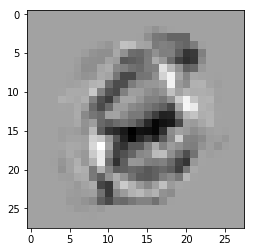

In [23]:
slope_smd,track_smd,var_smd,reg_smd = sto_md(X_train,y_train,20000,np.zeros(784),1,500)
slope_reshape = slope_smd.reshape(28,28)
plt.imshow(slope_reshape, cmap='gray')
plt.show()

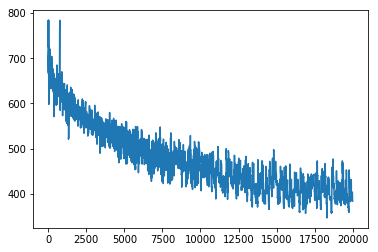

In [24]:
# Nombre de coordonnées non nulles

nb_non_nul_smd = []
for k in range(20000):
    nb_non_nul_smd.append(np.sum(np.abs(track_smd[k]) < 0.01))
plt.plot(range(20000),nb_non_nul_smd)

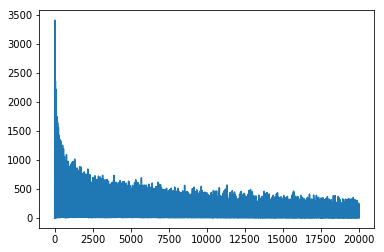

In [25]:
# Variations du paramètre
plt.plot(range(20000),var_smd)


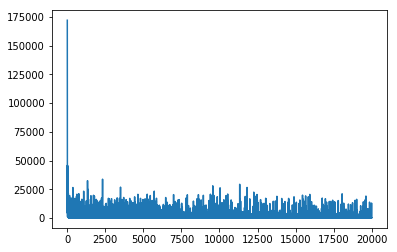

In [26]:
# Regret
plt.plot(range(20000),reg_smd)


# Stochastic EG+-

In [27]:
def sto_eg(x_data,y_data,n_iter,l_coeff,r):
    
    dim = x_data.loc[1,].shape[0] # taille du vecteur
    n = x_data.shape[0] # nombre de données
    
    w = np.repeat(1/(2*dim),2*dim) # Vecteur des poids 
    
    #Initialisation de theta
    theta = np.zeros(dim) 
    for i in range(dim):
        theta[i] = r*(w[i] - w[i+dim]) 
        
    # Learning rate
    eta = r*np.sqrt((np.log(dim))/(n_iter*dim))
    
    W = np.zeros(dim*2)
    
    #theta
    theta_track = []
    theta_var = []
    var = 0
    
    #regret
    reg = []
    sum_theta = 0
    
    for t in tqdm(range(n_iter)):
        
        ind = int(np.random.randint(n,size=1)) # choix d'une donnée
        J = int(np.random.choice(2*dim,1,p=w)) # choix d'un des experts
        j = J%784 # indice de l'expert choisi
        
        x = theta 
        a = np.array(x_data.loc[ind,])
        b = y_data[ind] 
        instgrad = loss_grad(x,a,b,l_coeff) + x 
        instgrad = instgrad[j]
        for k in range(dim*2):
            W[k] = w[k]
            
        if j <= dim:
            W[j] = np.exp(-eta*(instgrad))*w[j]
        else:
            W[j] = np.exp(eta*instgrad)*w[j]
        
        s = np.sum(W)
        
        for k in range(dim*2):
            w[k] = W[k]/s
            
        for i in range(dim):
            theta[i] = r*(w[i]-w[i+dim])
            
        theta_track.append(theta)
        
        #regret instantané
        
        sum_theta += theta 
        moy_theta = sum_theta/(t+1)
        
        instant_regret = float(insthingereg(moy_theta,a,b,l_coeff))
        reg.append(instant_regret)
        
        #variations de paramètres
        if t > 2:
            var = np.sum(np.abs(theta_track[t]-theta_track[t-1]))
        theta_var.append(var)
        
    return(theta,theta_track,theta_var,reg)

100%|██████████| 10000/10000 [00:20<00:00, 491.68it/s]


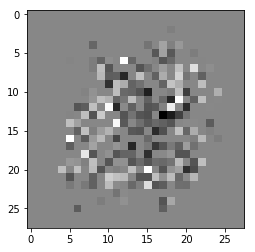

In [28]:
slope_eg,track_eg,var_eg,reg_eg = sto_eg(X_train,y_train,10000,1/40,20)
slope_reshape = slope_eg.reshape(28,28)
plt.imshow(slope_reshape, cmap='gray')
plt.show()



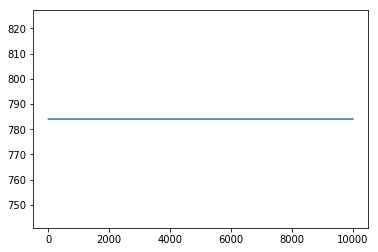

In [29]:
# Nombre de coordonnées non nulles

nb_non_nul_eg = []
for k in range(10000):
    nb_non_nul_eg.append(np.sum(np.abs(track_eg[k]) < 0.01))
plt.plot(range(10000),nb_non_nul_eg)

# Normal puisque l'on fixe la norme a chaque fois a r 

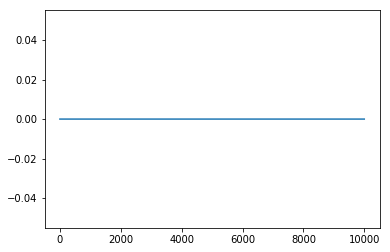

In [30]:
# Variations du paramètre
plt.plot(range(10000),var_eg)

# Encore une fois constant, car lié a l'algorithme. 
# En moyenne de variation absolue, pas de variation

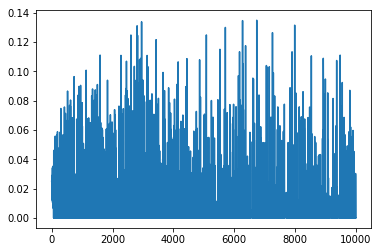

In [31]:
# Regret
plt.plot(range(10000),reg_eg)


# Adagrad 

In [32]:
def sto_adaproj(x_data,y_data,init,n_iter,l_coeff,r):
    
    dim = x_data.loc[1,].shape[0] # taille du vecteur
    n = x_data.shape[0] # nombre de données
    
    s = np.repeat(1/(4*dim),dim)
    theta = init
    eta = 2*r
    
    #theta
    theta_track = []
    theta_var = []
    var = 0
    
    #regret
    reg = []
    sum_theta = 0
    
    for t in tqdm(range(n_iter)):
        ind = int(np.random.randint(n,size=1)) # choix d'une donnée
        a = np.array(x_data.loc[ind,])
        b = y_data[ind]
        
        x = theta
        s = s + (loss_grad(x,a,b,l_coeff) + x)**2
        y = x - eta*1/np.sqrt(s)*(loss_grad(x,a,b,l_coeff)+ x)
        theta = pib1w(y,np.sqrt(s),r)
        
        theta_track.append(theta)
        
        #regret instantané
        
        sum_theta += theta 
        moy_theta = sum_theta/(t+1)
        
        instant_regret = float(insthingereg(moy_theta,a,b,l_coeff))
        reg.append(instant_regret)
        
        
        if t > 2:
            var = np.sum(np.abs(theta_track[t]-theta_track[t-1]))
        theta_var.append(var)
        
    return(theta,theta_track,theta_var,reg)

100%|██████████| 10000/10000 [00:05<00:00, 1669.09it/s]


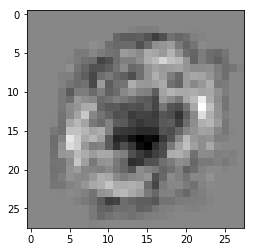

In [33]:
slope_ada,track_ada,var_ada,reg_ada = sto_adaproj(X_train,y_train,np.repeat(2000,784),10000,1,1)
slope_reshape = slope_ada.reshape(28,28)
plt.imshow(slope_reshape, cmap='gray')
plt.show()

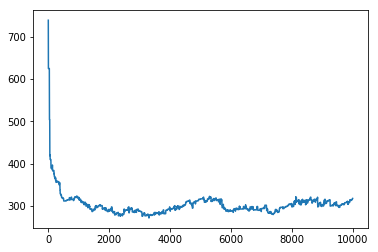

In [34]:
# Nombre de coordonnées non nulles

nb_non_nul_ada = []
for k in range(10000):
    nb_non_nul_ada.append(np.sum(np.abs(track_ada[k]) < 0.01))
plt.plot(range(10000),nb_non_nul_ada)

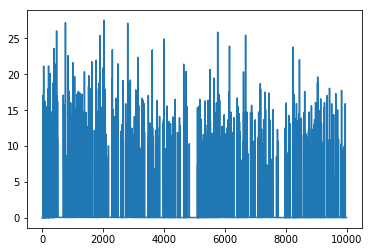

In [35]:
# Variations du paramètre
plt.plot(range(10000),var_ada)


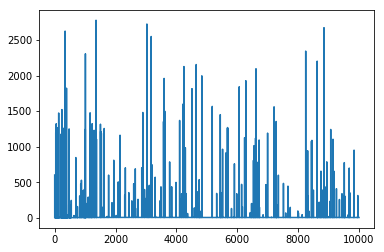

In [36]:
# Regret
plt.plot(range(10000),reg_ada)


# Online Newton Step

In [37]:
def sto_onsproj(x_data,y_data,init,n_iter,l_coeff,r):
    
    dim = x_data.loc[1,].shape[0] # taille du vecteur
    n = x_data.shape[0] # nombre de données 
    
    gamm = (1/2)*min(1/(8*r),1)
    gamm2 = 1/((gamm**2)*(2*r)**2)
    s = np.repeat(gamm2,dim)
    
    theta = init 
    
    #theta
    theta_track = []
    theta_var = []
    var = 0
    
    #regret
    reg = []
    sum_theta = 0
    
    for t in tqdm(range(n_iter)):
        
        ind = int(np.random.randint(n,size=1)) # choix d'une donnée
        a = np.array(x_data.loc[ind,])
        b = y_data[ind]      
        
        x = theta
        s = s + ( loss_grad(x,a,b,l_coeff) + x )**2
        y = theta - (1/gamm)*(1/s)* ( loss_grad(x,a,b,l_coeff) + x )
        theta = pib1w(y,s,r)
        theta_track.append(theta)
        
        #regret instantané
        
        sum_theta += theta 
        moy_theta = sum_theta/(t+1)
        
        instant_regret = float(insthingereg(moy_theta,a,b,l_coeff))
        reg.append(instant_regret)
        
        if t > 2:
            var = np.sum(np.abs(theta_track[t]-theta_track[t-1]))
        theta_var.append(var)
        
    return(theta,theta_track,theta_var,reg)

100%|██████████| 10000/10000 [00:05<00:00, 1757.79it/s]


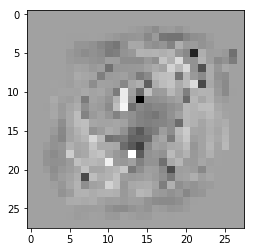

In [38]:
slope_ons,track_ons,var_ons,reg_ons = sto_onsproj(X_train,y_train,np.zeros(784),10000,1,1)
slope_reshape = slope_ons.reshape(28,28)
plt.imshow(slope_reshape, cmap='gray')
plt.show()

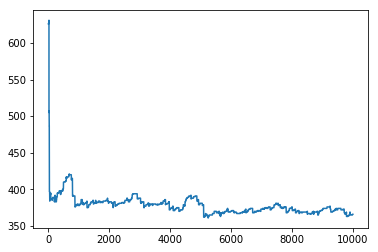

In [39]:
# Nombre de coordonnées non nulles

nb_non_nul_ons = []
for k in range(10000):
    nb_non_nul_ons.append(np.sum(np.abs(track_ons[k]) < 0.01))
plt.plot(range(10000),nb_non_nul_ons)

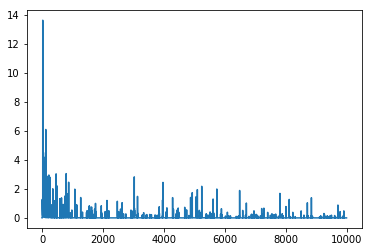

In [40]:
# Variations du paramètre
plt.plot(range(10000),var_ons)

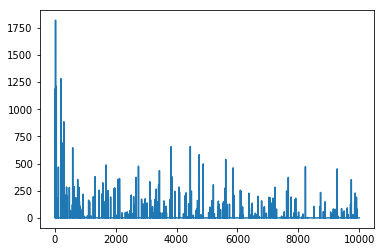

In [41]:
# Regret
plt.plot(range(10000),reg_ons)


# Evaluation 

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
def classif(x,slope):
    return(np.sign(slope.dot(x)))

## SGD

In [44]:
res_sgd = []
n = X_test.shape[0]
for i in range(n): 
    res_sgd.append(classif(X_test.iloc[i,],slope_sgd))

In [45]:
accuracy_score(res_sgd,y_test)

0.9836

## GD simple

In [46]:
#res_gd = []
#n = X_test.shape[0]
#for i in range(n): 
#    res_gd.append(classif(X_test.iloc[i,],slope_gd))

In [47]:
#accuracy_score(res_gd,y_test)

## SMD

In [48]:
res_smd = []
n = X_test.shape[0]
for i in range(n): 
    res_smd.append(classif(X_test.iloc[i,],slope_smd))

In [49]:
accuracy_score(res_smd,y_test)

# Lambda = 1 et projection environ 210 250 pas plus 

0.902

# EG+-

In [50]:
res_eg = []
n = X_test.shape[0]
for i in range(n): 
    res_eg.append(classif(X_test.iloc[i,],slope_eg))

In [51]:
accuracy_score(res_eg,y_test)



0.96

# Adagrad

In [52]:
res_ada = []
n = X_test.shape[0]
for i in range(n): 
    res_ada.append(classif(X_test.iloc[i,],slope_ada))

In [53]:
accuracy_score(res_ada,y_test)



0.9692

# Online Newton Step

In [54]:
res_ons = []
n = X_test.shape[0]
for i in range(n): 
    res_ons.append(classif(X_test.iloc[i,],slope_ons))

In [55]:
accuracy_score(res_ons,y_test)



0.9818

# Comparaison

In [56]:
slope_smd,track_smd,var_smd,reg_smd = sto_md(X_train,y_train,10000,np.zeros(784),1,500)

100%|██████████| 10000/10000 [00:04<00:00, 2401.23it/s]


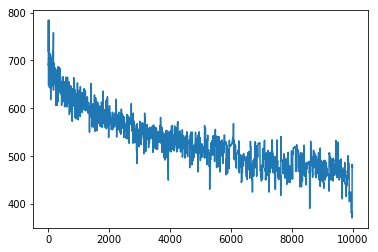

In [57]:
nb_non_nul_smd = []
for k in range(10000):
    nb_non_nul_smd.append(np.sum(np.abs(track_smd[k]) < 0.01))
plt.plot(range(10000),nb_non_nul_smd)

## Normalized Cumulative Regret

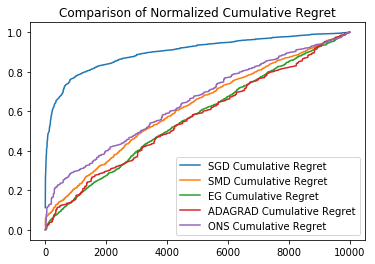

In [58]:
sgd = np.array(reg_sgd) 
s_sgd = np.cumsum(sgd)
normalized_sgd = s_sgd/s_sgd[9999]

smd = np.array(reg_smd) 
s_smd = np.cumsum(smd)
normalized_smd = s_smd/s_smd[9999]

eg = np.array(reg_eg) 
s_eg = np.cumsum(eg)
normalized_eg = s_eg/s_eg[9999]

ada = np.array(reg_ada) 
s_ada = np.cumsum(ada)
normalized_ada = s_ada/s_ada[9999]

ons = np.array(reg_ons) 
s_ons = np.cumsum(ons)
normalized_ons = s_ons/s_ons[9999]



plt.title("Comparison of Normalized Cumulative Regret")
plt.plot(range(10000),normalized_sgd,"C0",label="SGD Cumulative Regret") 
plt.plot(range(10000),normalized_smd,"C1",label="SMD Cumulative Regret")
plt.plot(range(10000),normalized_eg,"C2",label="EG Cumulative Regret")
plt.plot(range(10000),normalized_ada,"C3",label="ADAGRAD Cumulative Regret")
plt.plot(range(10000),normalized_ons,"C4",label="ONS Cumulative Regret")
plt.legend()

## Non null coordinates

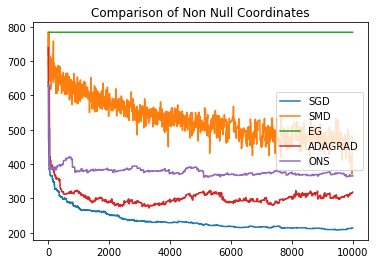

In [59]:
sgd_coord = nb_non_nul_sgd
smd_coord = nb_non_nul_smd
eg_coord = nb_non_nul_eg
ada_coord = nb_non_nul_ada
ons_coord = nb_non_nul_ons

plt.title("Comparison of Non Null Coordinates")
plt.plot(range(10000),sgd_coord,"C0",label="SGD") 
plt.plot(range(10000),smd_coord,"C1",label="SMD")
plt.plot(range(10000),eg_coord,"C2",label="EG")
plt.plot(range(10000),ada_coord,"C3",label="ADAGRAD")
plt.plot(range(10000),ons_coord,"C4",label="ONS")
plt.legend()

## Evolution of some support vectors 

In [60]:
# We get the most important coordinates

ind_sgd = slope_sgd.argsort()[-5:][::-1] 
ind_smd = slope_smd.argsort()[-5:][::-1] 
ind_eg = slope_eg.argsort()[-5:][::-1] 
ind_ada = slope_ada.argsort()[-5:][::-1] 
ind_ons = slope_ons.argsort()[-5:][::-1] 



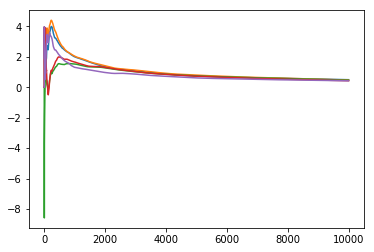

In [61]:
# For SGD it stabilizes fast

sgd = {}
for ind in ind_sgd:
    vec = []
    for k in range(10000):
        vec.append(track_sgd[k][ind])
    sgd[str(ind)] = vec
    
for key,values in sgd.items():
    plt.plot(values,label=key)

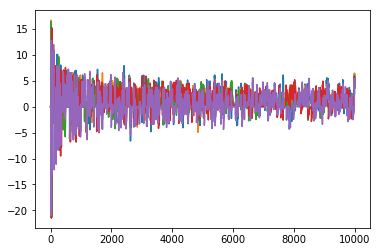

In [62]:
# For SMD, many fluctuations and doesnt seem to stabilize, maybe 
# some optimization on hyperparameters needed

smd = {}
for ind in ind_smd:
    vec = []
    for k in range(10000):
        vec.append(track_smd[k][ind])
    smd[str(ind)] = vec
    
for key,values in smd.items():
    plt.plot(values,label=key)

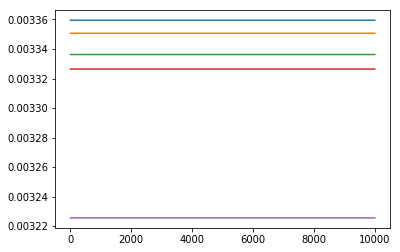

In [63]:
# For EG, coordinates got low very fast... 

eg = {}
for ind in ind_eg:
    vec = []
    for k in range(10000):
        vec.append(track_eg[k][ind])
    eg[str(ind)] = vec
    
for key,values in eg.items():
    plt.plot(values,label=key)

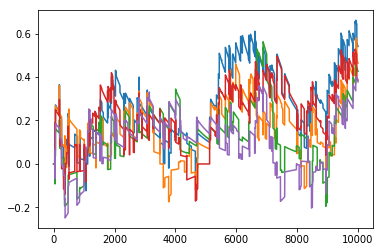

In [64]:
# For Adagrad, Many fluctuations, the model doesnt seem to stabilize 

ada = {}
for ind in ind_ada:
    vec = []
    for k in range(10000):
        vec.append(track_ada[k][ind])
    ada[str(ind)] = vec
    
for key,values in ada.items():
    plt.plot(values,label=key)

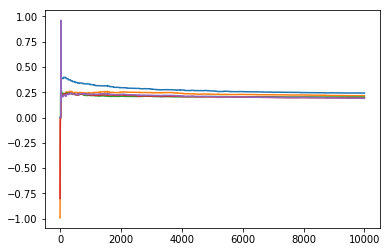

In [65]:
# ONS seems to stabilize the fastest 

ons = {}
for ind in ind_ons:
    vec = []
    for k in range(10000):
        vec.append(track_ons[k][ind])
    ons[str(ind)] = vec
    
for key,values in ons.items():
    plt.plot(values,label=key)